# Business Questions
## Neighbourhood is related to the price
Features we will use:
- accommodates
- bathrooms
- bedrooms
- beds
- Price

## The occupancy rate is related to Neighbourhood.
## The number of rooms, bathrooms, and beds is related to the price

# Data Understanding

## Reading Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import warnings 
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", None)

### Functions

In [2]:
def PlotBarplotorBoxplot(df, _x, _y, _tp, _orient = 'v', _title = None):
    """
    Description: This function can be used to plot a boxplot when _tp = "boxplot" or barplot when _tp = "barplot"
    
    Arguments:
        df: dataframe with the data 
        _x: x-axis
        _y: y-axis
        _tp: barplot or boxplot
        _orient: horizontal or vertical barplot. Needs to imput h to horizontal or v to vertical 
        _title: title of the visualization 
    Returns:
        plot a  boxplot or barplot
    """
    try:
        if _title == None and _y != None:
            _title = _x + " x " + _y
        elif _title != None:
            _title = _title
        else:
            _title = _x 
        if _tp == "boxplot":
            plt.figure(figsize = (25,10))
            plt.title(_title, size = 20)
            sns.boxplot(data=df_abt, x=_x, y=_y,orient=_orient)
            plt.show()
        elif _tp =="barplot":
            plt.figure(figsize = (25,10))
            plt.title(_title, size = 20)
            sns.barplot(data = df, x = _x, y = _y, orient =_orient)
            plt.show()
    except:
        print("Error! Review your code")
        
def LinearRegressionCoefInterpretation(coef):
    """
    Description: This function can be used to determine whether a coefficient of multiple linear regression increases or decreases to indicate its relationship with the price. 
    
    Arguments:
        coef: multiple linear regression coefficient
    Returns:
        returns if price increases or decreases
    """
    if coef > 0:
        return f"The price + {coef}"
    else:
        return f"The price {coef}"


## Reading Data

In [3]:
df_calendar = pd.read_csv('/calendar.csv', encoding= 'unicode_escape')
df_listings = pd.read_csv('/listings.csv', encoding= 'unicode_escape')
df_reviews = pd.read_csv('/reviews.csv')
print(f"Dates from {df_calendar['date'].min()} to {df_calendar['date'].max()}")

Dates from 2016-01-04 to 2017-01-02


## Data Verification

### Calendar

In calendar data we have price NULL when is booked

In [4]:
df_calendar.isna().sum()

listing_id         0
date               0
available          0
price         459028
dtype: int64

In [5]:
df_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


### listings

In reviews we have 18 NULL comments but we won't use this information.

In [6]:
df_reviews.isna().sum()

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         18
dtype: int64

In [7]:
colunas_missing_listings = df_listings.columns[df_listings.isna().mean() > 0].values
df_listings[['accommodates', 'bathrooms', 'bedrooms','beds','price', 'neighbourhood_group_cleansed']].isna().sum()

accommodates                     0
bathrooms                       16
bedrooms                         6
beds                             1
price                            0
neighbourhood_group_cleansed     0
dtype: int64

As we will be using bathroom, bedrooms, beds and price data to answer a business question, we cannot consider missing values, as assigning the median, mean, or even filling defaults like 0 would influence the results obtained. So we will drop these values from our dataset !

In [8]:
df_listings = df_listings.dropna(subset = ['bathrooms', 'bedrooms','beds','price'])
df_listings[['accommodates', 'bathrooms', 'bedrooms','beds','price', 'neighbourhood_group_cleansed']].isna().sum()

accommodates                    0
bathrooms                       0
bedrooms                        0
beds                            0
price                           0
neighbourhood_group_cleansed    0
dtype: int64

## Data Preparation

In [9]:
df_listings['id'] = df_listings['id'].astype('str').str.zfill(10).astype('str')
df_listings['price'] = df_listings['price'].str.replace('$', '', regex = True).str.replace(',','', regex = True).str.replace('.','', regex=True).astype('float')
df_listings['id'] = df_listings['id'].astype('int64')

### Creating date columns and a column that will inform if the location is booked or not

In [10]:
df_calendar['date'] = pd.to_datetime(df_calendar['date'])
df_calendar['year_month'] = df_calendar['date'].dt.strftime('%Y-%m')
df_calendar['booked'] = df_calendar['available'].map({'t':0, 'f':1})


### Creating a dataframe to calculate the total booked

In [11]:
df_calendar_agg = (
    df_calendar
    .groupby('listing_id')
    .agg(
        qtd = ('listing_id', 'count'),
        total_booked = ('booked', 'sum'),
        taxa_ocupacao = ('booked', 'mean')
    )
    .reset_index()
)
df_calendar_agg['id']  = df_calendar_agg['listing_id'].astype('str').str.zfill(10).astype('str')
df_calendar_agg['id'] = df_calendar_agg['id'].astype('int64')

### Merging the calendar dataframe with listings dataframe

In [12]:
colunas = ['listing_id','qtd','total_booked','taxa_ocupacao', 'number_of_reviews', 'property_type','neighbourhood_group_cleansed', 'market','neighbourhood_cleansed', 
           'accommodates', 'bathrooms','bedrooms', 'beds', 'bed_type', 'price', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value'
          ]
df_abt = pd.merge(df_listings, df_calendar_agg, left_on = 'id', right_on = 'listing_id', how = 'inner')[colunas]
df_abt.isna().sum()

listing_id                        0
qtd                               0
total_booked                      0
taxa_ocupacao                     0
number_of_reviews                 0
property_type                     1
neighbourhood_group_cleansed      0
market                            0
neighbourhood_cleansed            0
accommodates                      0
bathrooms                         0
bedrooms                          0
beds                              0
bed_type                          0
price                             0
review_scores_rating            643
review_scores_accuracy          654
review_scores_cleanliness       649
review_scores_checkin           654
review_scores_communication     647
review_scores_location          651
review_scores_value             652
dtype: int64

### Removing rows with review scores null

As we will be using review data to answer a business question, we cannot consider missing values, as assigning the median, mean, or even filling defaults like 0 would influence the results obtained. So we will drop these values from our dataset


In [13]:
df_abt = df_abt.dropna(subset = ['review_scores_accuracy','review_scores_checkin','review_scores_value'])
df_abt.isna().sum()

listing_id                      0
qtd                             0
total_booked                    0
taxa_ocupacao                   0
number_of_reviews               0
property_type                   0
neighbourhood_group_cleansed    0
market                          0
neighbourhood_cleansed          0
accommodates                    0
bathrooms                       0
bedrooms                        0
beds                            0
bed_type                        0
price                           0
review_scores_rating            0
review_scores_accuracy          0
review_scores_cleanliness       0
review_scores_checkin           0
review_scores_communication     0
review_scores_location          0
review_scores_value             0
dtype: int64

### DF Final


Since Neighbourhood is a categorical feature, we would apply a method called One-Hot-Encoding, which creates a new column for each category of the feature and assigns a binary value of 0 or 1. The disadvantage of this method is that when we have numerous categorical features with many categories, it ends up making the dataset have a large number of variables, which is not our case.



In [14]:
numerical_features = ['accommodates', 'bathrooms', 'bedrooms','beds']

df_abt[numerical_features] = df_abt[numerical_features].astype(int)
df_abt_modeling = df_abt[['accommodates', 'bathrooms', 'bedrooms','beds','neighbourhood_cleansed', 'price']]
df_modeling_final = pd.get_dummies(df_abt_modeling, prefix = "neighbourhood_")
X = df_modeling_final.drop('price', axis = 1)
Y = df_modeling_final['price']
x_train, x_test, y_train, y_test = train_test_split(X,Y, random_state = 123, train_size= 0.7)

# Modeling 
## Neighbourhood is related to the price.


In [15]:
df_agg_question_1 = (
    df_abt[['neighbourhood_group_cleansed','total_booked','taxa_ocupacao', 'price', 'review_scores_location']]
    .groupby('neighbourhood_group_cleansed')
    .median()
    .reset_index()
    .sort_values(by='price', ascending = False)
)
df_agg_question_1

,neighbourhood_group_cleansed,total_booked,taxa_ocupacao,price,review_scores_location
9,Magnolia,8.0,0.021918,15000.0,10.0
6,Downtown,74.5,0.204110,13900.0,10.0
12,Queen Anne,86.0,0.235616,12000.0,10.0
3,Cascade,118.0,0.323288,11500.0,10.0
2,Capitol Hill,65.0,0.178082,10950.0,10.0
16,West Seattle,38.0,0.104110,10000.0,10.0
4,Central Area,62.0,0.169863,9950.0,10.0
11,Other neighborhoods,50.0,0.136986,9500.0,10.0
0,Ballard,57.0,0.156164,9500.0,10.0
14,Seward Park,29.0,0.079452,9000.0,9.0


## The occupancy rate is related to Neighbourhood.

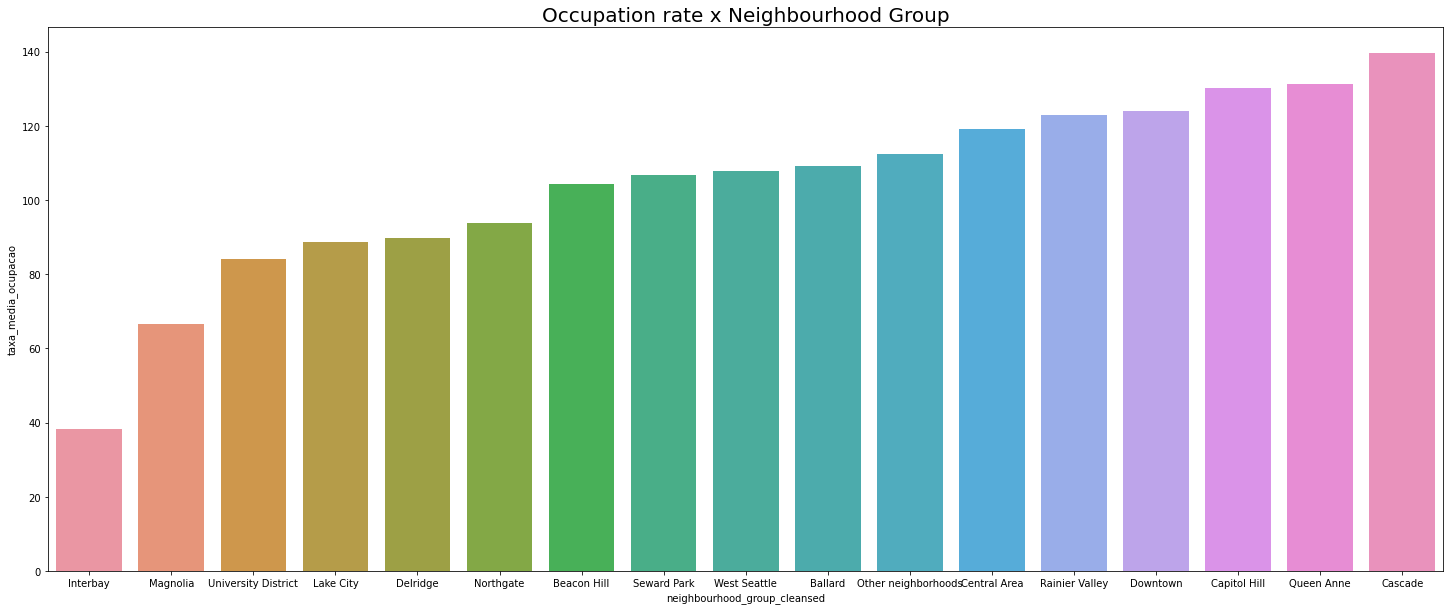

In [16]:
df_abt_agg= df_abt.groupby(['neighbourhood_group_cleansed']).agg(taxa_media_ocupacao = ('total_booked', 'mean')).sort_values(by = 'taxa_media_ocupacao').reset_index()
PlotBarplotorBoxplot(df = df_abt_agg, _x = 'neighbourhood_group_cleansed', _y = 'taxa_media_ocupacao', _tp = 'barplot', _title ="Occupation rate x Neighbourhood Group")

## The number of rooms, bathrooms, and beds is related to the pirce

Podemos observar que conforme a quantidade de camas aumenta, maior é o preço do aluguel do imovel

### Bivariate

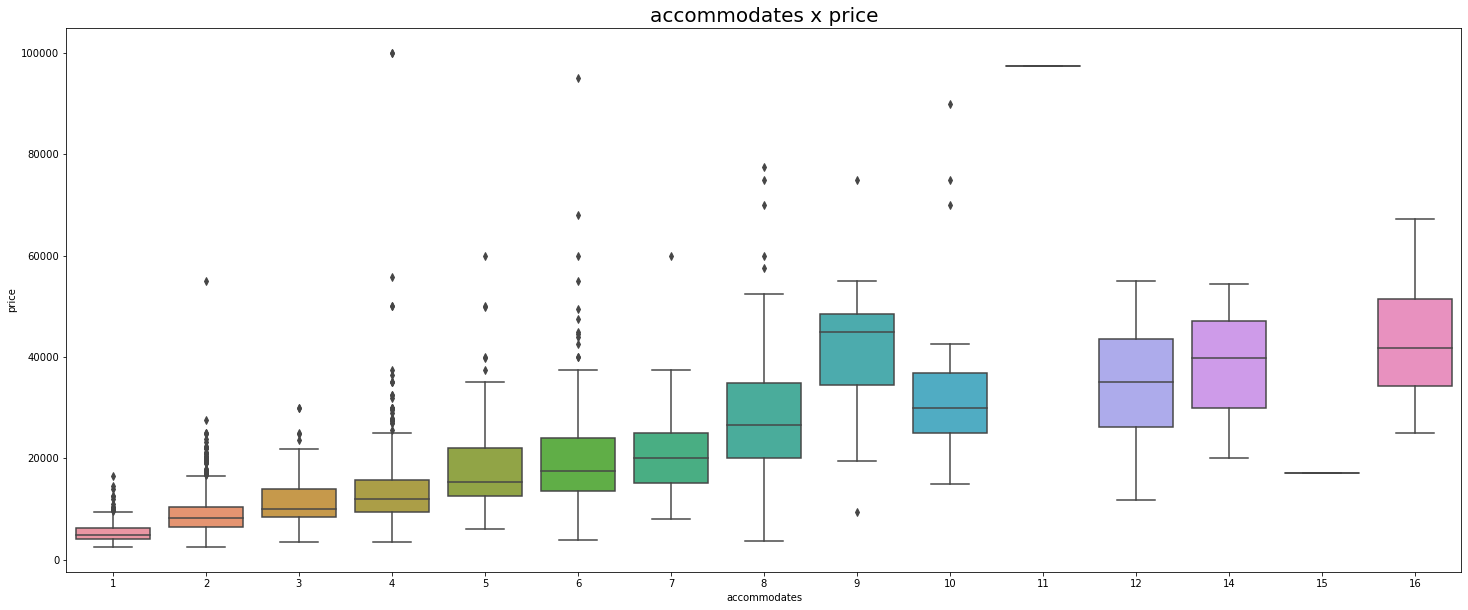

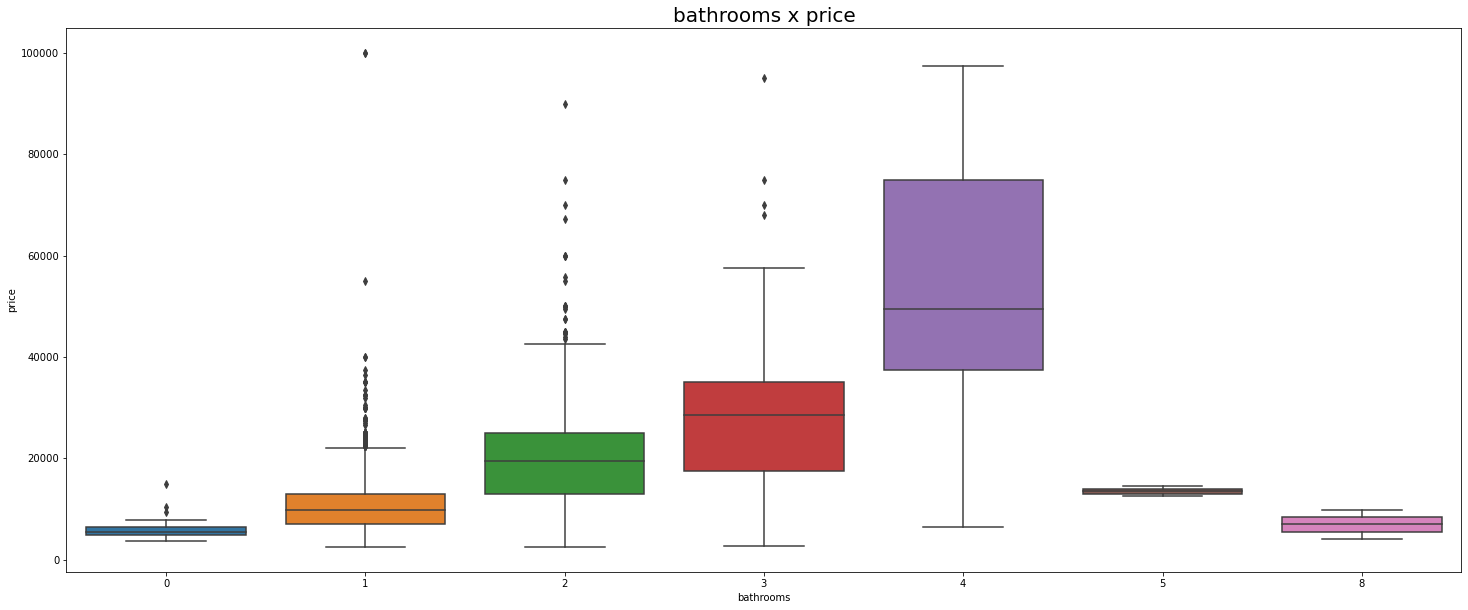

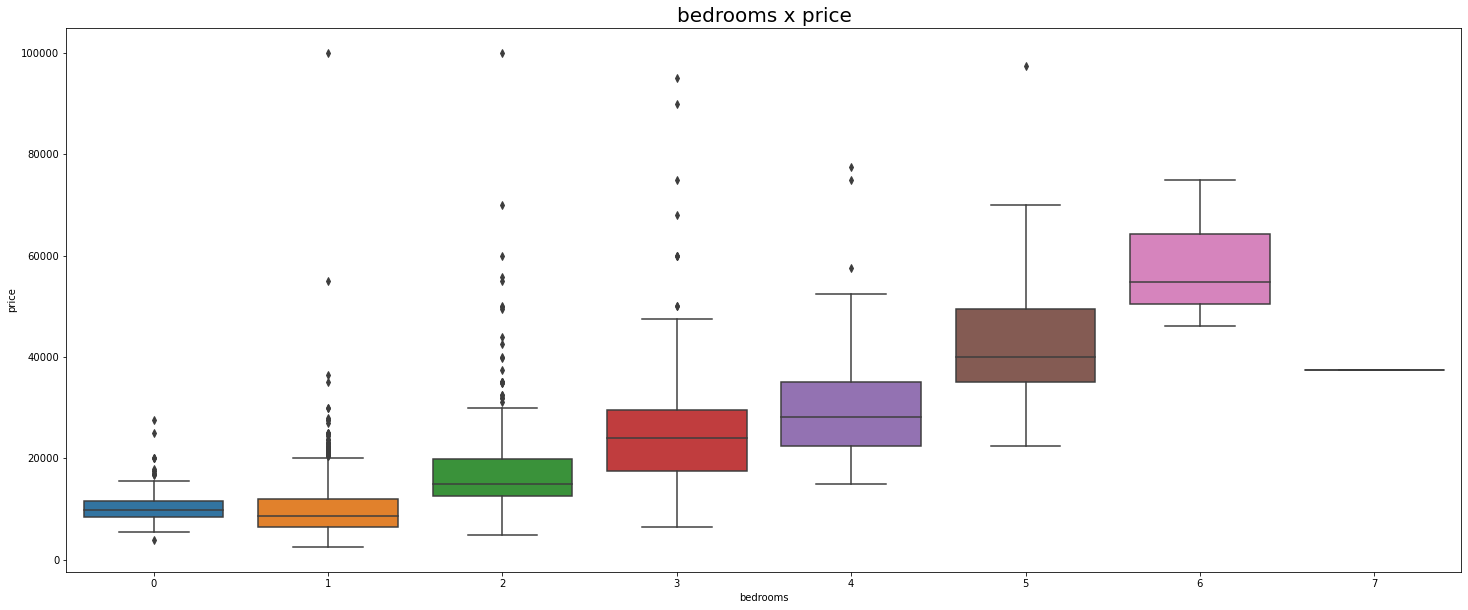

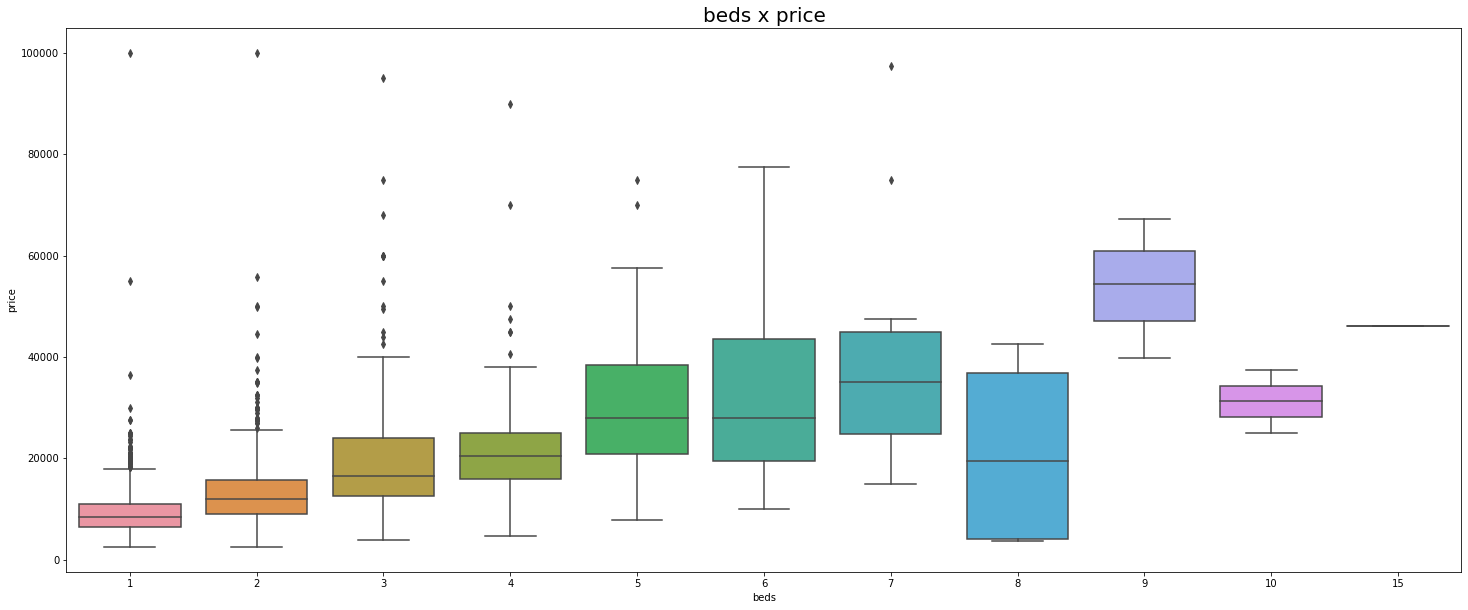

In [17]:
PlotBarplotorBoxplot(df = df_abt, _x = 'accommodates', _y = 'price', _tp ="boxplot", _title = None)
PlotBarplotorBoxplot(df = df_abt, _x = 'bathrooms', _y = 'price', _tp ="boxplot", _title = None)
PlotBarplotorBoxplot(df = df_abt, _x = 'bedrooms', _y = 'price', _tp ="boxplot", _title = None)
PlotBarplotorBoxplot(df = df_abt, _x = 'beds', _y = 'price', _tp ="boxplot", _title = None)


### Univariate

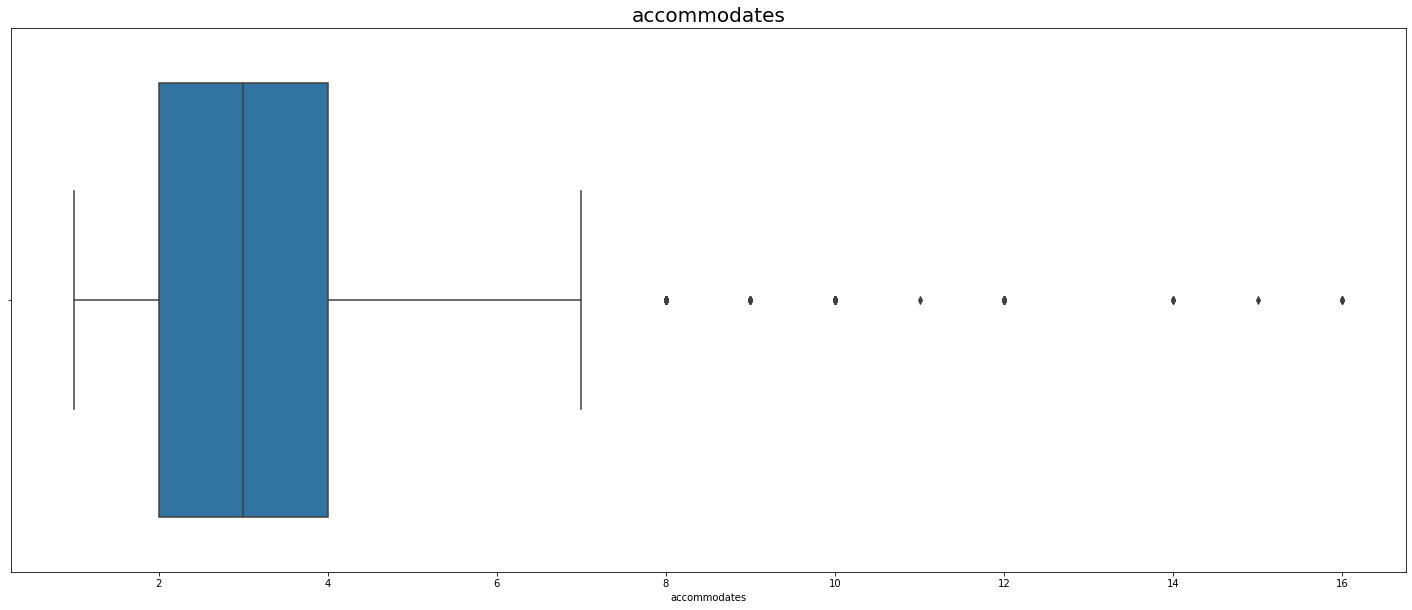

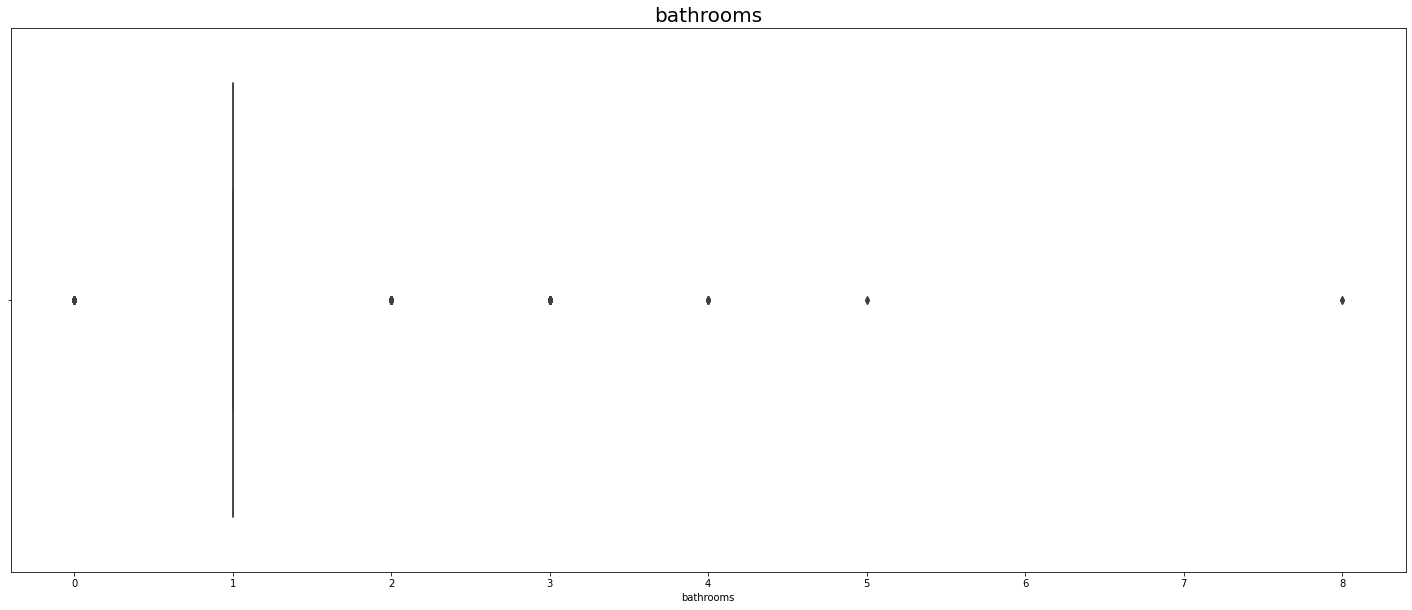

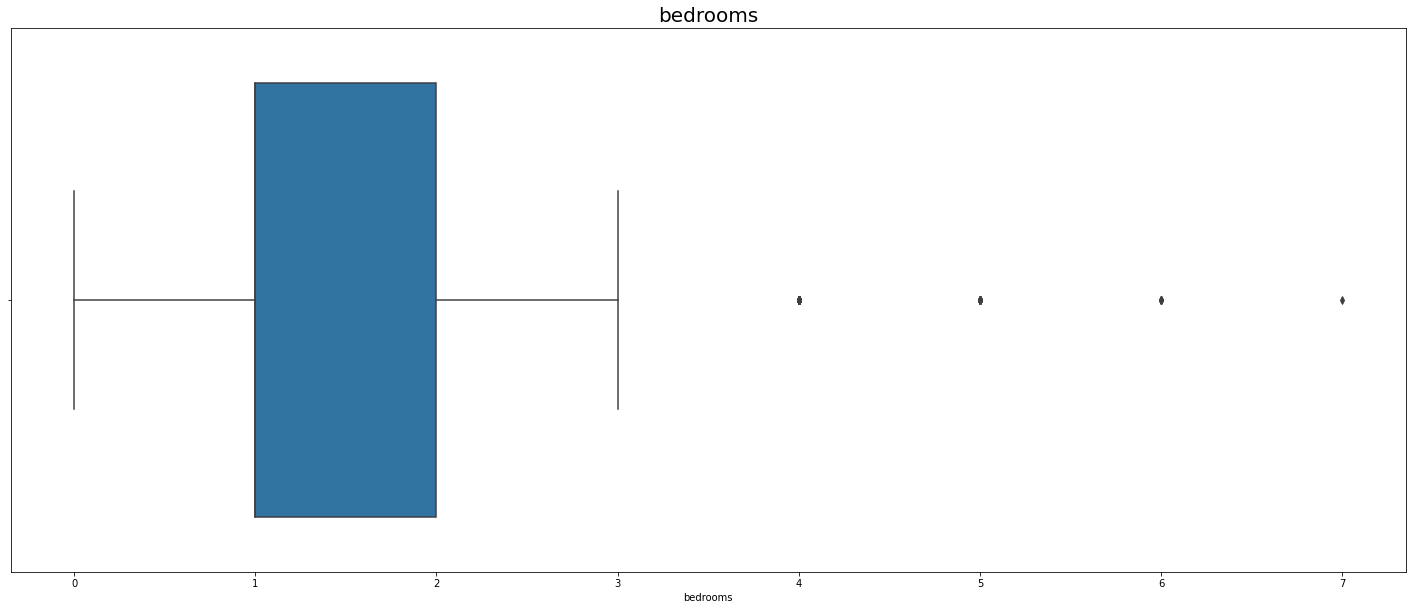

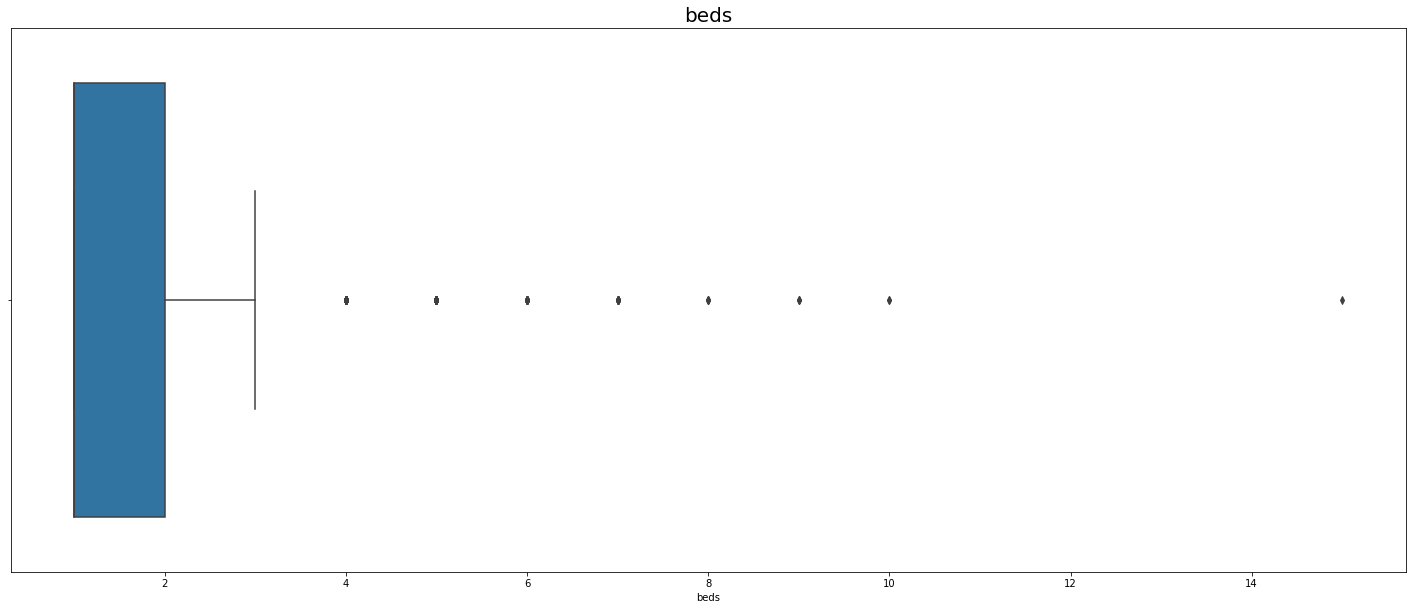

In [18]:
numerical_features = ['accommodates', 'bathrooms', 'bedrooms','beds']

for order, feature in enumerate(numerical_features):
    PlotBarplotorBoxplot(df = df_abt, _x = feature, _y =None, _tp ="boxplot", _title = None)


## Fitting Model

In [19]:
import statsmodels.api as sm
X2 = sm.add_constant(x_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     31.08
Date:                Fri, 01 Sep 2023   Prob (F-statistic):          8.85e-317
Time:                        23:44:49   Log-Likelihood:                -22197.
No. Observations:                2198   AIC:                         4.457e+04
Df Residuals:                    2108   BIC:                         4.509e+04
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [20]:
df_result = pd.DataFrame(est2.params, columns = ['coef']).reset_index()
df_result['result'] = df_result['coef'].apply(lambda x: LinearRegressionCoefInterpretation(x))
df_neighbourhood_negative = df_result[(df_result['coef'] < 0) & ( ~ df_result['index'].isin(['const', 'accommodates', 'bathrooms','bedrooms', 'beds']))].sort_values(by='coef', ascending = False).head(10)
df_neighbourhood_positive = df_result[(df_result['coef'] > 0) & ( ~ df_result['index'].isin(['const', 'accommodates', 'bathrooms','bedrooms', 'beds']))].sort_values(by='coef', ascending = False).head(10)


# Results

## Neighbourhood is related to the price


Como podemos observar com os resultados obtidos pelo modelo de regressão linear multipla, a variável de Neighbourhood está associada com relação ao valor do Preço. 
Abaixo podemos ver que as cidades com o maior preço (utilizando a mediana)

In [27]:
df_agg_question_2 = (
    df_abt[['neighbourhood_group_cleansed', 'price']]
    .groupby('neighbourhood_group_cleansed')
    .median()
    .reset_index()
    .sort_values(by='price', ascending = False)
)
df_agg_question_2

,neighbourhood_group_cleansed,price
9,Magnolia,15000.0
6,Downtown,13900.0
12,Queen Anne,12000.0
3,Cascade,11500.0
2,Capitol Hill,10950.0
16,West Seattle,10000.0
4,Central Area,9950.0
11,Other neighborhoods,9500.0
0,Ballard,9500.0
14,Seward Park,9000.0


With the visualizations below, we can see the results of multiple linear regression, where we interpret the coefficients and identify which neighborhoods have the most influence on increasing or decreasing the price.

### Top 10 Neighbourhood that increase or decrease the price value

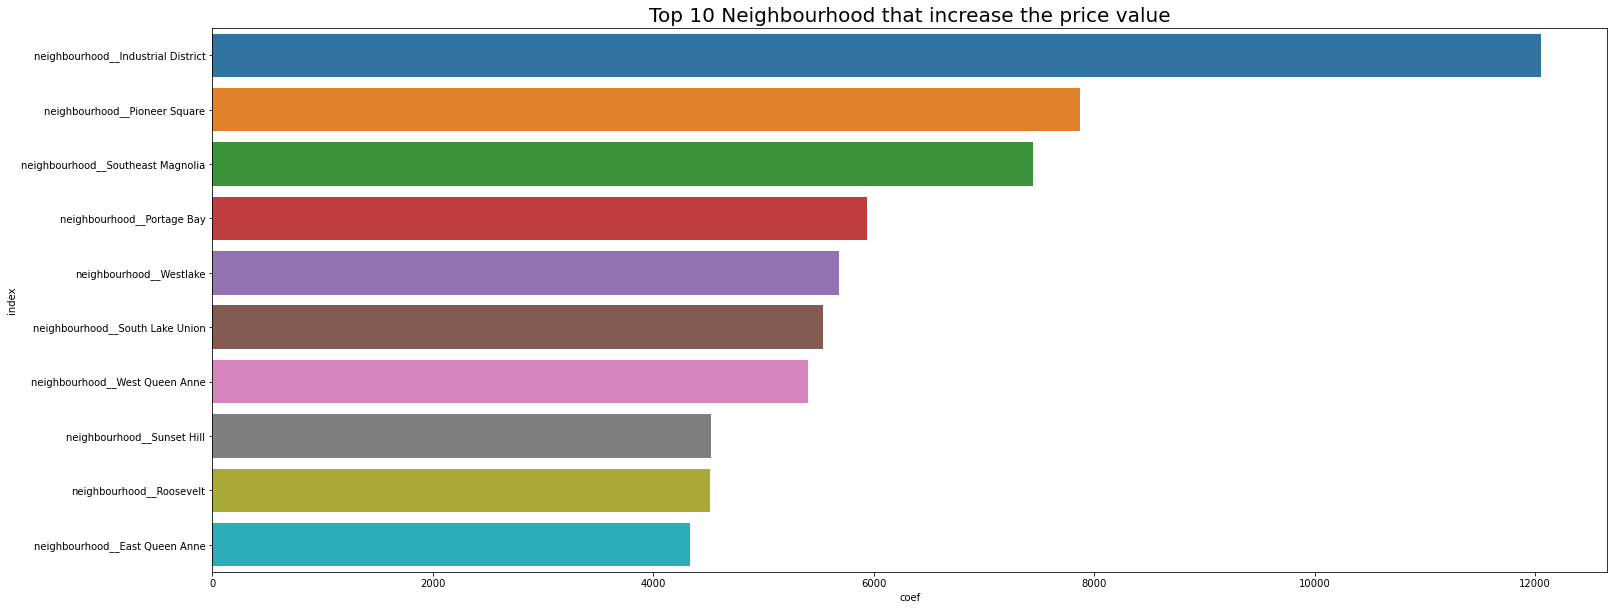

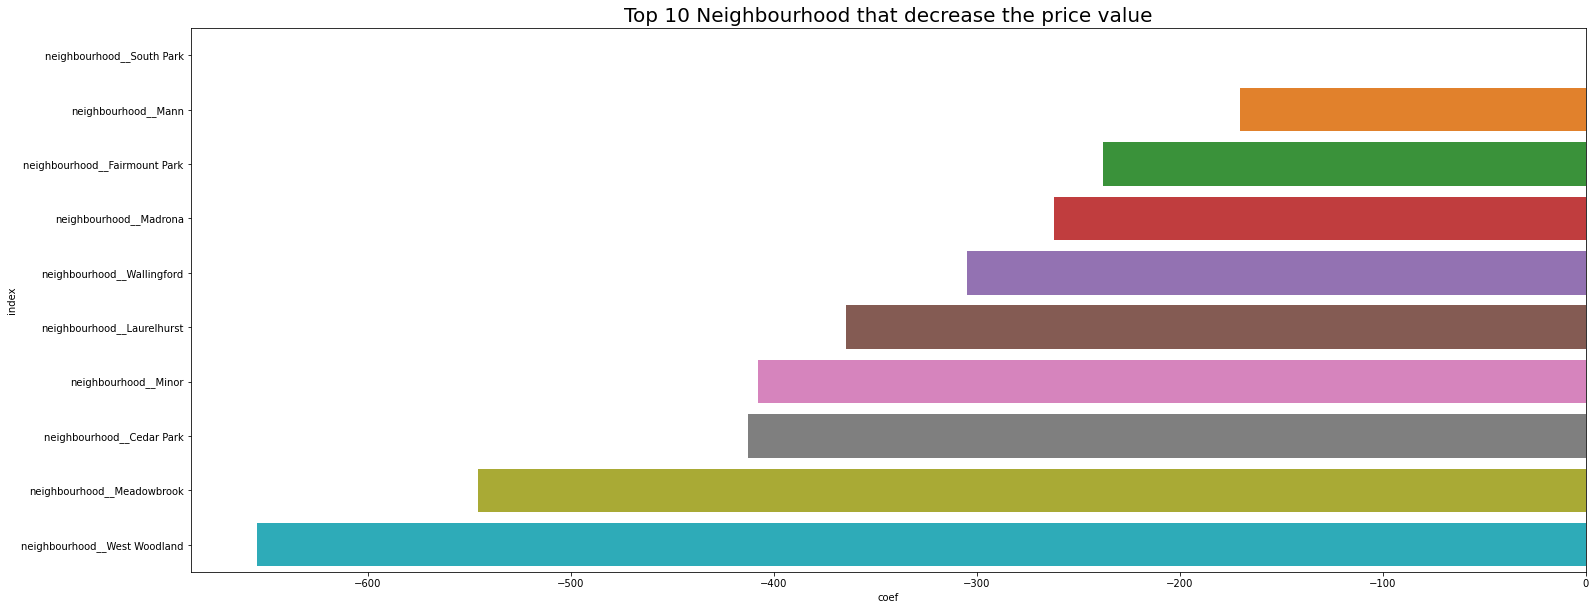

In [22]:
PlotBarplotorBoxplot(df = df_neighbourhood_positive, _x = 'coef', _y = 'index', _tp ="barplot",_orient = 'h', _title = "Top 10 Neighbourhood that increase the price value" )
PlotBarplotorBoxplot(df = df_neighbourhood_negative, _x = 'coef', _y = 'index', _tp ="barplot",_orient = 'h', _title = "Top 10 Neighbourhood that decrease the price value" )

## The occupancy rate is related to Neighbourhood.

We can observe that the occupancy rate has a strong relationship with the neighborhood, where we find that Interbay is the least occupied neighborhood, and Cascade is the most occupied one.

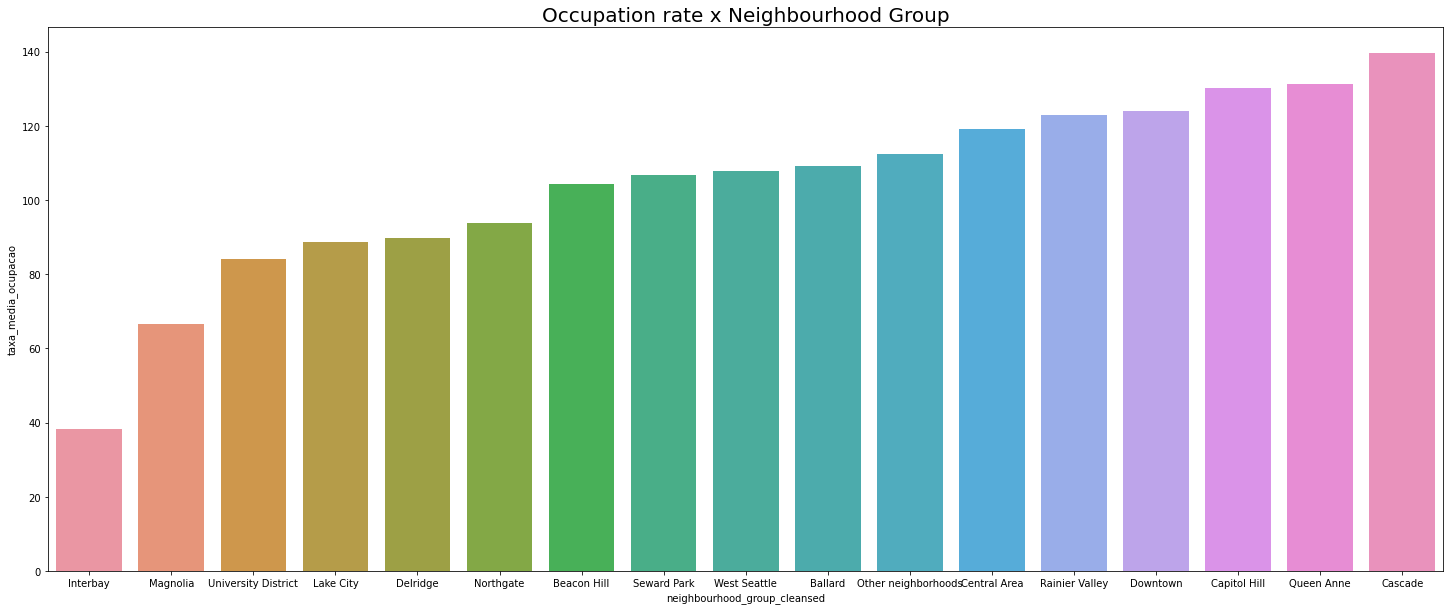

In [23]:
PlotBarplotorBoxplot(df = df_abt_agg, _x = 'neighbourhood_group_cleansed', _y = 'taxa_media_ocupacao', _tp = 'barplot', _title ="Occupation rate x Neighbourhood Group")

## The number of rooms, bathrooms, and beds is related to the price

We can observe that we have a positive relationship between the number of accommodates, bathrooms, bedrooms, and beds concerning the price. Another point is that when interpreting the multiple linear regression model, we see that the model coefficients are positive to accommodates, bathrooms and bedrooms, and the features are statistically significant (p-value < 0.05) in explaining our price feature.






In [24]:
df_result.query(f"index in ('accommodates', 'bathrooms', 'bedrooms', 'beds')")

,index,coef,result
1,accommodates,1618.097821,The price + 1618.0978206366176
2,bathrooms,2357.321220,The price + 2357.321220198816
3,bedrooms,3421.929813,The price + 3421.92981269559
4,beds,-486.555245,The price -486.5552445195902


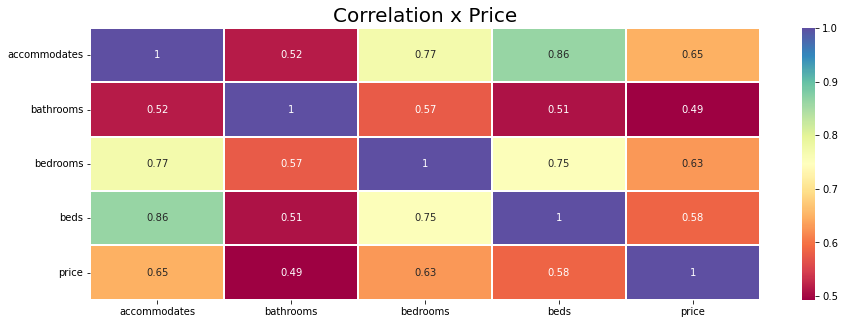

In [25]:
colunas = ['accommodates', 'bathrooms', 'bedrooms','beds','price']
plt.figure(figsize = (15,5))
plt.title("Correlation x Price", size =20)
sns.heatmap(df_abt[colunas].corr(), annot=True, linewidth = 1.5,cmap="Spectral")
plt.show()